<h1>Attempt1: Linear regression of relative frequency of words</h1>

As a first attempt, we tried to use linear regression to estimate the changing rate of relative frequency of each word and select those words with the highest rate of increasing relative frequency to represent trends. Specifically, we 
1. Cleaned the raw data, removed as many references as possible. 
2. Used CountVectorizer with a modified tokenizer to do preprocessing and counted frequencies of unigrams and bigrams. This is done for both abstracts and full texts. 
3. Normalized the frequency of each word to the length of each article as the relative frequency. 
4. Binned papers based on their years of publication and calculated the average relative frequency of each word for each year. 
5. Conducted a linear regression of average relative frequency of words as a function of time and selected words with highest positive slope. These words show increasing relative frequency over time and thus represent a trend.

For unigram, abstracts and full texts share 5 out of 10. For bigram, abstracts and full texts only share 2 out of 10. We selected 5 unigrams and 5 bigrams that have real meanings. These terms are either shared between abstracts and full texts or selected from abstract alone, because we think ngrams selected from the abstract are more representative. 

<h3> The words that represent trends include: 'bound', 'distribution', 'graph', 'matrix', 'method', 'machine learning', 'high dimensional', 'convex optimization', 'latent variable', and 'inference algorithm'</h3>

In [59]:
import os
import glob

## Basic data processing and plotting libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from datetime import datetime
from time import time

# Text pipeline and NLP packages

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords  
from nltk.stem.porter import PorterStemmer
import string

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim import corpora, models 
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.models import word2vec  

from pyemd import emd  

# SciKit NMF and LDA package and some easy text data
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE, MDS

from sklearn.linear_model import LinearRegression

<h3> Load raw data, sort based on year and calculate number of articles each year </h3>

In [82]:
## Load raw data
nips_raw = pd.read_pickle("nips-papers/nips-papers.pkl")
nips_raw.head()

,id,year,title,abstract,text,refs
0,1,1987,Self-Organization of Associative Database and ...,An efficient method of self-organizing associa...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[Hopfield, J. J. and D. W. Tank, ""Computing wi..."
1,2,1987,The Capacity of the Kanerva Associative Memory...,The capacity of an associative memory is defin...,184\n\nTHE CAPACITY OF THE KANERVA ASSOCIATIVE...,"[R.J. McEliece, E.C. Posner, E.R. Rodemich, an..."
2,3,1987,Supervised Learning of Probability Distributio...,We propose that the back propagation algorithm...,52\n\nSupervised Learning of Probability Distr...,"[Werbos,P, ""Beyond Regression: New Tools for P..."
3,4,1987,Constrained Differential Optimization,Many optimization models of neural networks ne...,612\n\nConstrained Differential Optimization\n...,"[K. J. Arrow, L. Hurwicz, H. Uzawa, Studies in..."
4,5,1987,Towards an Organizing Principle for a Layered ...,An information-theoretic optimization principl...,485\n\nTOWARDS AN ORGANIZING PRINCIPLE FOR\nA ...,"[[2], [4], [6], [8], [10], [12]\n\nR. Linsker,..."


In [83]:
print(nips_raw.shape)
## Sort the df based on publish year 
nips_raw = nips_raw.sort_values(by="year")
nips_raw.reset_index(inplace = True)

(7241, 6)


In [84]:
## Number of publications per year 
num_papers_per_year = nips_raw["year"].value_counts()
num_papers_per_year

2017    679
2016    569
2014    411
2015    403
2012    368
2013    360
2011    306
2010    292
2009    262
2008    250
2007    217
2005    207
2004    207
2002    207
2006    204
2003    198
2001    197
1993    158
1995    152
2000    152
1996    152
1998    151
1999    150
1997    150
1991    144
1990    143
1994    140
1992    127
1989    101
1988     94
1987     90
Name: year, dtype: int64

<h3> Preprocess of abstracts and full texts and calculate total number of words for each abstract/article </h3>

In [85]:
# Preprocessing of abstracts and full texts 
# Preprocessed texts are still stored in the dataframe 

## Convert to lowercase
nips_raw.loc[:,'abstract'] = nips_raw['abstract'].apply(lambda x: x.lower())
nips_raw.loc[:,'text'] = nips_raw['text'].apply(lambda x: x.lower())

## Make a copy and use the copy to make tokens and remove stop words 
## The copy (nips_processed) is only used for counting total number of words for each abstract/paper 
nips_processed = nips_raw.copy()
## Define stopwords 
stops = set(stopwords.words("english")) #stops
stops = stops.union(['I'])
## Initiate tokenizer 
##tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer('(?ui)\\b[a-z]{3,}\\w*\\b')
## tokenize and remove stopwords 
nips_processed.loc[:,'abstract'] = nips_processed['abstract'].apply(lambda x: tokenizer.tokenize(x)) 
nips_processed.loc[:,'abstract'] = nips_processed['abstract'].apply(lambda x: [word for word in x if word not in stops]) 
nips_processed.loc[:,'text'] = nips_processed['text'].apply(lambda x: tokenizer.tokenize(x)) 
nips_processed.loc[:,'text'] = nips_processed['text'].apply(lambda x: [word for word in x if word not in stops])

In [86]:
nips_processed.head()

,index,id,year,title,abstract,text,refs
0,0,1,1987,Self-Organization of Associative Database and ...,"[efficient, method, self, organizing, associat...","[self, organization, associative, database, ap...","[Hopfield, J. J. and D. W. Tank, ""Computing wi..."
1,65,68,1987,Schema for Motor Control Utilizing a Network M...,"[paper, outlines, schema, movement, control, b...","[schema, motor, control, utilizing, network, m...","[M. Ito, The Cerebellum and Neural Control (Ra..."
2,64,67,1987,Generalization of Back propagation to Recurren...,"[general, method, deriving, backpropagation, a...","[generalization, backpropagation, recurrent, h...","[(2), (4), (6), (8)\n\nI. J. HopfieJd. Neural ..."
3,63,66,1987,On Properties of Networks of Neuron-Like Elements,"[complexity, computational, capacity, multi, l...","[properties, networks, neuron, like, elements,...","[Y. S. Abu-Mostafa, ""Number of synapses per ne..."
4,62,65,1987,Minkowski-r Back-Propagation: Learning in Conn...,"[many, connectionist, learning, models, implem...","[minkowski, back, propaaation, learnine, conne...","[Rumelhart D. E., Hinton G. E., Williams R., L..."


In [87]:
## Compute the length of each abstract and paper after tokenization and removing stop words 
abstracts_length = nips_processed['abstract'].apply(lambda x: len(x))
print(abstracts_length.head())
papers_length = nips_processed['text'].apply(lambda x: len(x))
print(papers_length.head())

0    44
1    87
2    26
3    87
4    80
Name: abstract, dtype: int64
0    1627
1    1748
2    1831
3    2142
4    1134
Name: text, dtype: int64


<h3> Tokenize/lemmatize abstracts and full texts respectively, and count term frequencies </h3>

In [115]:
# Self defined tokenizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.rt = RegexpTokenizer('(?ui)\\b[a-z]{3,}\\w*\\b')

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in self.rt.tokenize(doc)]


# Function to build tf (raw term count) features from the corpus 
# texts should be lower case corpora with special characters removed
def build_tf(texts, n_features, ngram):
    ## Only extract the top n_features features/words
    stops = set(stopwords.words("english")) 
    stops = stops.union(['I'])

    ## Corpus does not work here
    ## Need to supply a list of strings and each string corresponds to a paper 
    print("Extracting tf features...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                    decode_error='ignore',
                                    strip_accents='unicode',
                                    max_features=n_features,
                                    ngram_range = (ngram,ngram),
                                    stop_words = stops,
                                    tokenizer=LemmaTokenizer(),
                                    token_pattern=u'(?ui)\\b[a-z]{3,}\\w*\\b')
                                    
    t0 = time()
    tf = tf_vectorizer.fit_transform(texts)
    print("done in %0.3fs." % (time() - t0))
    print()

    print("\nThe shape of our count vector matrix: ",tf.shape)
    print(tf_vectorizer.get_feature_names()[:30])
    print("=======================")

    tf_array = tf.toarray()
    return [tf_array, tf_vectorizer.get_feature_names()]

In [116]:
# Build tf (raw term count) features from the corpus 
n_features = 1000

## nips_raw should be reused here; 
## tokenization and stop words removal is done using countVectorizer 
abstract_tf_n1 = build_tf(nips_raw['abstract'], n_features=n_features, ngram=1)
abstract_tf_n2 = build_tf(nips_raw['abstract'], n_features=n_features, ngram=2)
paper_tf_n1 = build_tf(nips_raw['text'], n_features=n_features, ngram=1)
paper_tf_n2 = build_tf(nips_raw['text'], n_features=n_features, ngram=2)

Extracting tf features...
done in 4.553s.


The shape of our count vector matrix:  (7241, 1000)
['ability', 'able', 'according', 'account', 'accuracy', 'accurate', 'accurately', 'achieve', 'achieved', 'achieves', 'achieving', 'across', 'action', 'activation', 'active', 'activity', 'adaptation', 'adaptive', 'addition', 'additional', 'additive', 'address', 'advantage', 'adversarial', 'agent', 'aim', 'algorithm', 'alignment', 'allow', 'allowing']
Extracting tf features...
done in 6.349s.


The shape of our count vector matrix:  (7241, 1000)
['able learn', 'achieves state', 'across different', 'action potential', 'action space', 'activation function', 'active learning', 'actor critic', 'address issue', 'address problem', 'adversarial network', 'algorithm achieves', 'algorithm allows', 'algorithm also', 'algorithm applied', 'algorithm based', 'algorithm called', 'algorithm estimate', 'algorithm find', 'algorithm ha', 'algorithm including', 'algorithm learn', 'algorithm learning', 'algorithm

<h3> Calculate average relative frequency of words per year </h3>

In [117]:
# Function to compute text length normalized relative frequency of words for each year (per 1000 words)

def relative_frequency_per_year(tf_array, num_papers_per_year, texts_length, years = (1987,2018)):
    ## Iteration of texts and years
    count,n = 0,0
    ## Initiate an empty matrix (year by words)
    tf_norm = np.zeros([num_papers_per_year.shape[0],tf_array.shape[1]])

    ## Iterate over each year and 
    for i in list(range(years[0],years[1])):
        ## Total number of papers for ith year 
        num_papers = num_papers_per_year[i]
        print(f'Current year: {i}')
        print(f'Index of paper to start: {count}')
        print(f'Number of papers in this year: {num_papers}')
        ## subset word tokens from papers for ith year
        tf_tmp = tf_array[count:(count+num_papers),:]
        ## For each article Compute relative frequency of each word
        ## Normalized by length of each article and scaled by 1000
        tf_tmp = tf_tmp / texts_length[count:(count+num_papers),np.newaxis] * 1000
        ## Take the mean of relative frequency of each word across all papers of ith year 
        tf_norm[n,:] = tf_tmp.mean(axis=0)
    
        count = count + num_papers
        n += 1
        print(f'Index of paper to finish: {count}')
        print("=========")
        
    return tf_norm
    


In [118]:
## text length normalized relative frequency of words for single word of abstract
abstract_n1_tf_norm = relative_frequency_per_year(abstract_tf_n1[0], num_papers_per_year, abstracts_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

In [119]:
## text length normalized relative frequency of words for double words of abstract
abstract_n2_tf_norm = relative_frequency_per_year(abstract_tf_n2[0], num_papers_per_year, abstracts_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

In [120]:
## text length normalized relative frequency of words for single word of paper
paper_n1_tf_norm = relative_frequency_per_year(paper_tf_n1[0], num_papers_per_year, papers_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

In [121]:
## text length normalized relative frequency of words for double word of paper
paper_n2_tf_norm = relative_frequency_per_year(paper_tf_n2[0], num_papers_per_year, papers_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 90
Index of paper to finish: 90
Current year: 1988
Index of paper to start: 90
Number of papers in this year: 94
Index of paper to finish: 184
Current year: 1989
Index of paper to start: 184
Number of papers in this year: 101
Index of paper to finish: 285
Current year: 1990
Index of paper to start: 285
Number of papers in this year: 143
Index of paper to finish: 428
Current year: 1991
Index of paper to start: 428
Number of papers in this year: 144
Index of paper to finish: 572
Current year: 1992
Index of paper to start: 572
Number of papers in this year: 127
Index of paper to finish: 699
Current year: 1993
Index of paper to start: 699
Number of papers in this year: 158
Index of paper to finish: 857
Current year: 1994
Index of paper to start: 857
Number of papers in this year: 140
Index of paper to finish: 997
Current year: 1995
Index of paper to start: 997
Number of papers in this year: 152
Index of paper to f

<h3> Linear regression to calculate the rate of relative frequency change </h3>

In [122]:
# Conduct a linear regression for relative frequency of each word as a function of time 
# Store word the R2 and slope of the resulting linear model

def tf_linear_regression(tf_norm, words):
    coef = []
    rsquare = []
    lm = LinearRegression()
    
    ## Iterate over each word and do a linear regression as a function of time
    for i in range(tf_norm.shape[1]):
        x = np.array(list(range(tf_norm.shape[0]))).reshape(-1,1)
        y = tf_norm[:,i].reshape(-1,1)
        lm.fit(x,y)
        rsquare.append(lm.score(x,y))
        coef.append(float(lm.coef_))
    
    ## Make a df out of words, slope and R2 of the linear model for each word
    tmp = np.array([words, coef, rsquare])
    tmp = tmp.T
    term_freq = pd.DataFrame(tmp)
    term_freq.columns = ["word", "coef", "R2"]
    
    ## Adjust data type
    term_freq.coef = term_freq.coef.astype(float)
    term_freq.R2 = term_freq.R2.astype(float)
    
    return (term_freq)
    

In [123]:
abstract_n1_term_freq = tf_linear_regression(tf_norm = abstract_n1_tf_norm, words = abstract_tf_n1[1])
abstract_n2_term_freq = tf_linear_regression(tf_norm = abstract_n2_tf_norm, words = abstract_tf_n2[1])
paper_n1_term_freq = tf_linear_regression(tf_norm = paper_n1_tf_norm, words = paper_tf_n1[1])
paper_n2_term_freq = tf_linear_regression(tf_norm = paper_n2_tf_norm, words = paper_tf_n2[1])

<h3> Select words with the highest rate of increasing relative frequency to represent trends </h3>

In [187]:
# Function to select words with highest increasing rate of frequency to represent trends

def trend_words(term_freq):
    ## Sort the df by slope and only keep words with R2 > 0.6
    ## Print the first 10 words, which correspond to words with increasing relative frequency over time 
    term_freq2 = term_freq.sort_values(by= ["coef"], ascending=False)
    term_freq2 = term_freq2.loc[term_freq2["R2"] > 0.6,]
    trend_terms = term_freq2.word[:10]
    return(trend_terms)

<h4> Unigram trends detected from abstracts </h4>

In [188]:
## Abstract with single word 
abstract_n1_trend_terms = trend_words(abstract_n1_term_freq)
abstract_n1_trend_terms

552          method
813            show
694         problem
450       inference
94            bound
707         propose
257    distribution
403           graph
537          matrix
808         setting
Name: word, dtype: object

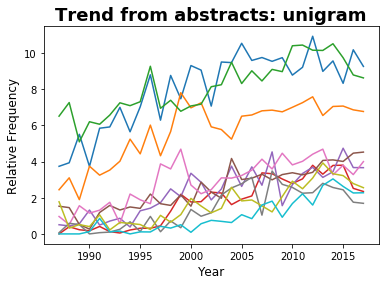

In [219]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n1_tf_norm[:,abstract_n1_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from abstracts: unigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h4> Bigram trends detected from abstracts </h4>

In [190]:
## Abstract with double words
abstract_n2_trend_terms = trend_words(abstract_n2_term_freq)
abstract_n2_trend_terms

879              state art
477       machine learning
348       high dimensional
781             real world
671          paper propose
155    convex optimization
757          propose novel
421        latent variable
907         synthetic real
376    inference algorithm
Name: word, dtype: object

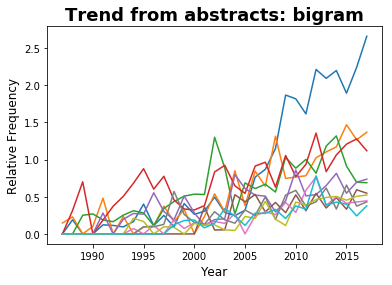

In [218]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n2_tf_norm[:,abstract_n2_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from abstracts: bigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h4> Unigram trends detected from full texts </h4>

In [193]:
## Full text with single word 
paper_n1_trend_terms = trend_words(paper_n1_term_freq)
paper_n1_trend_terms

25        algorithm
509             log
261    distribution
544          method
532          matrix
91            bound
776          sample
513            loss
912         theorem
397           graph
Name: word, dtype: object

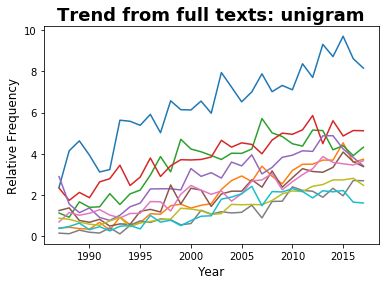

In [222]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             paper_n1_tf_norm[:,paper_n1_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from full texts: unigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h4> Bigram trends detected from full texts </h4>

In [194]:
## Full text with double words
paper_n2_trend_terms = trend_words(paper_n2_term_freq)
paper_n2_trend_terms

461                   log log
471               lower bound
466             loss function
635      optimization problem
848                 state art
470                  low rank
874    supplementary material
954               upper bound
472          machine learning
331           graphical model
Name: word, dtype: object

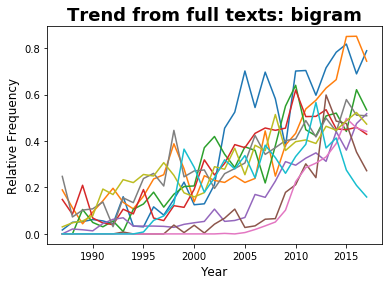

In [223]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             paper_n2_tf_norm[:,paper_n2_trend_terms.index[i]].reshape(-1,1))
plt.title('Trend from full texts: bigram', fontsize=18, fontweight="bold")
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Relative Frequency', fontsize = 12)
plt.show()

<h3> Shared trends between abstracts and full texts </h3>

In [139]:
## Shared single word between abstract and paper
np.intersect1d(abstract_n1_trend_terms, paper_n1_trend_terms)

array(['bound', 'distribution', 'graph', 'matrix', 'method'], dtype=object)

In [138]:
## Shared double words between abstract and paper
np.intersect1d(abstract_n2_trend_terms, paper_n2_trend_terms)

array(['machine learning', 'state art'], dtype=object)

<h3> Integrated results from unigrams and bigrams </h3>

<h4>Criteria</h4>
1. Select unigrams that are shared between abstracts and texts. This should remove words that are common in the abstract, like "show" and "propose". 
<br></br> 
2. Select bigrams mainly from abstracts, because the frequency of bigrams in full texts are very low, which reduces signals. Remove bigrams that collocate together, but have no special meanings. 
<br></br> 
3. Combine curated unigrams and bigrams. 
<br></br>

['bound', 'distribution', 'graph', 'matrix', 'method']


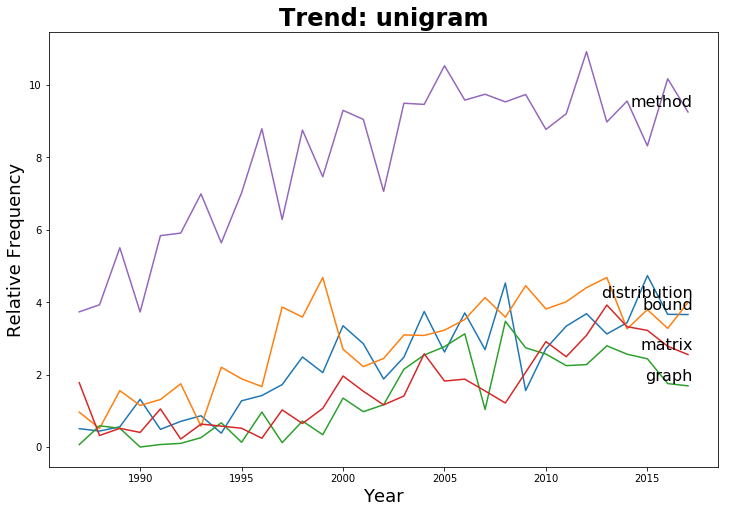

In [229]:
final_trend_unigram = ['bound', 'distribution', 'graph', 'matrix', 'method']
final_trend_unigram_index = [94, 257, 403, 537, 552]
print(final_trend_unigram)

x = np.array(list(range(1987,2018)))
y = abstract_n1_tf_norm[:,final_trend_unigram_index]

plt.figure(figsize=(12,8))
for i in list(range(5)):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n1_tf_norm[:,final_trend_unigram_index[i]].reshape(-1,1))
    plt.annotate(final_trend_unigram[i],
                     xy=(2017, abstract_n1_tf_norm[30,final_trend_unigram_index[i]]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                fontsize=16)

plt.title('Trend: unigram', fontsize=24, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Relative Frequency', fontsize=18)
plt.show()

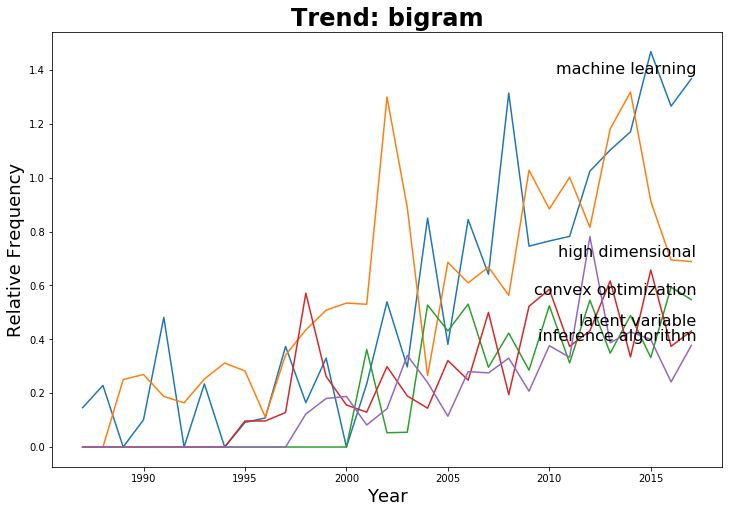

In [233]:
final_trend_bigram = ['machine learning', 'high dimensional', 'convex optimization', 
                      'latent variable', 'inference algorithm']
final_trend_bigram_index = [477, 348, 155, 421, 376]

x = np.array(list(range(1987,2018)))
y = abstract_n2_tf_norm[:,final_trend_bigram_index]

plt.figure(figsize=(12,8))
for i in list(range(5)):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n2_tf_norm[:,final_trend_bigram_index[i]].reshape(-1,1))
    plt.annotate(final_trend_bigram[i],
                     xy=(2017, abstract_n2_tf_norm[30,final_trend_bigram_index[i]]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                fontsize=16)

plt.title('Trend: bigram', fontsize=24, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Relative Frequency', fontsize=18)
plt.show()